In [1]:
## MRI and Alzheimers
# 데이터출처 : https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers

In [2]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

In [3]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'kimbyeongmin'
os.environ['KAGGLE_KEY'] = '7f7577c67517f64bb40fe70861fdbf61'

In [4]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!kaggle datasets download -d jboysen/mri-and-alzheimers
!unzip '*.zip'

mri-and-alzheimers.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  mri-and-alzheimers.zip
replace oasis_cross-sectional.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [13]:
!ls

mri-and-alzheimers.zip	   oasis_longitudinal.csv
oasis_cross-sectional.csv  sample_data


In [14]:
# pd.read_csv()로 csv파일 읽어들이기
data_cross = pd.read_csv("oasis_cross-sectional.csv")
data_long = pd.read_csv("oasis_longitudinal.csv")
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

In [15]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [16]:
data_cross.dropna(subset=['CDR'],inplace=True)

In [17]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

In [18]:
data = pd.concat([data_cross,data_long], ignore_index = True)
data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [19]:
data.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,608.000000,608.000000,570.00000,606.000000,608.000000,608.000000,608.00000,608.000000
mean,75.208882,10.184211,2.47193,27.234323,0.288651,1477.062500,0.73713,1.203597
std,9.865026,6.058388,1.12805,3.687980,0.377697,170.653795,0.04267,0.135091
min,33.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.64400,0.876000
25%,70.000000,4.000000,2.00000,26.000000,0.000000,1352.500000,0.70400,1.118000
50%,76.000000,12.000000,2.00000,29.000000,0.000000,1460.000000,0.73600,1.202000
75%,82.000000,16.000000,3.00000,30.000000,0.500000,1569.000000,0.76625,1.297500
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.84700,1.587000


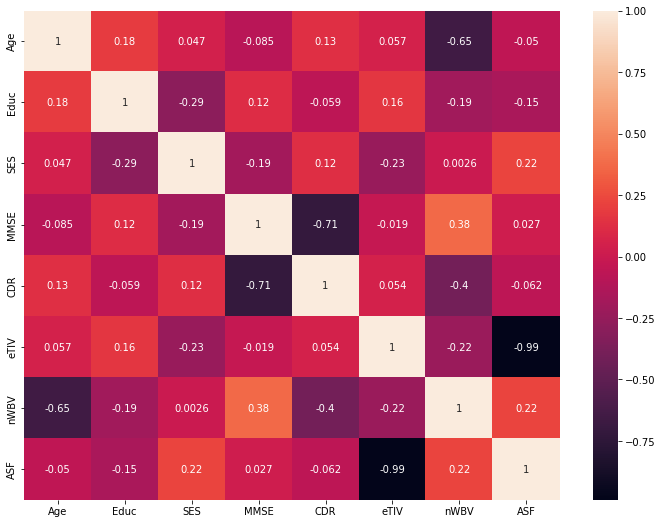

In [20]:
cor = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values,yticklabels=cor.columns.values, annot=True)

In [29]:
data.isna().sum()

M/F      0
Hand     0
Age      0
Educ     0
SES     38
MMSE     2
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [30]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [31]:
data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
603,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037
604,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040
605,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331
606,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323


In [33]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

In [34]:
data = pd.get_dummies(data)

<BarContainer object of 4 artists>

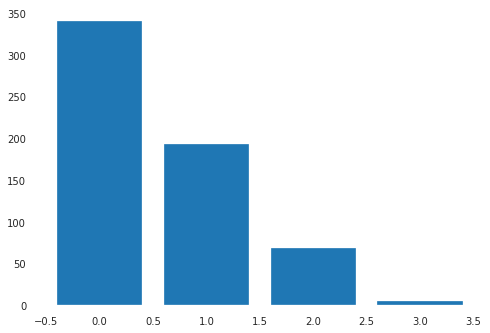

In [35]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

In [36]:
data = data.drop(data[data['CDR']==3].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603 entries, 0 to 607
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     603 non-null    int64  
 1   Educ    603 non-null    float64
 2   SES     603 non-null    float64
 3   MMSE    603 non-null    float64
 4   CDR     603 non-null    int64  
 5   eTIV    603 non-null    int64  
 6   nWBV    603 non-null    float64
 7   ASF     603 non-null    float64
 8   M/F_F   603 non-null    uint8  
 9   M/F_M   603 non-null    uint8  
 10  Hand_R  603 non-null    uint8  
dtypes: float64(5), int64(3), uint8(3)
memory usage: 44.2 KB


In [37]:
y = data.pop('CDR')
x = data

In [38]:
x = StandardScaler().fit_transform(x)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

In [40]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

{'learning_rate': 0.5, 'max_depth': 30, 'n_estimators': 103}

In [41]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7845303867403315

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1290: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.

{'criterion': 'mae',
 'learning_rate': 0.8,
 'loss': 'deviance',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 0.025,
 'n_estimators': 68,
 'subsample': 0.95}

In [44]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.8232044198895028


In [45]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1290: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). Use criterion='friedman_mse' or 'squared_error' instead, as trees should use a squared error criterion in Gradient Boosting.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:370: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.

0.7856284153005465

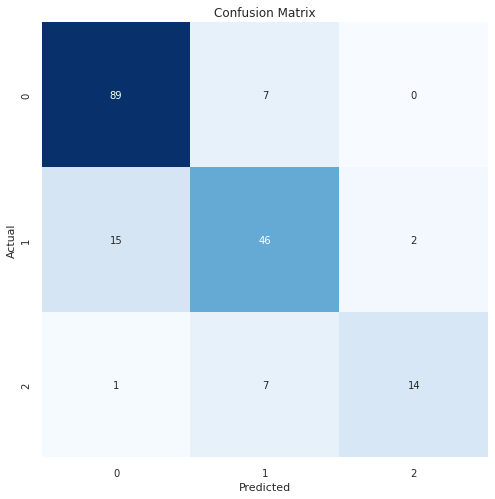

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        96
           1       0.77      0.73      0.75        63
           2       0.88      0.64      0.74        22

    accuracy                           0.82       181
   macro avg       0.83      0.76      0.79       181
weighted avg       0.82      0.82      0.82       181



In [46]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)